# Part 2: RNN

### Upload the dataset for creation of RNN, and check characteristics

In [10]:
pip install -U keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [keras-tuner]
Note: you may need to restart the kernel to use updated packages.


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping

In [13]:
def cyclic_encode(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / max_val)
    return df

In [17]:
# Charge the training dataset
# train_df = pd.read_csv("/content/train.csv")
# test_df = pd.read_csv("/content/test.csv")
base_dir = "/Users/filiporlikowski/Documents/APROF_CNN/RNN/bike-sharing"
train_df = pd.read_csv(f"{base_dir}/train/train.csv")
test_df = pd.read_csv(f"{base_dir}/test/test.csv")

datasets = [train_df, test_df]

for df in datasets:
    # Prove there are no missing values
    print("Missing values in training dataset:", df.isnull().sum().sum())

    for col in df.columns:
        print(f"nº unique values '{col}':", df[col].nunique())
        print(f"Name attributes '{col}':", df[col].unique())

    # 1. Convertir datetime i extreure característiques cíclicles
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['hour'] = df['datetime'].dt.hour
    df['dayofweek'] = df['datetime'].dt.dayofweek
    df['month'] = df['datetime'].dt.month
    df = cyclic_encode(df, 'hour', 23)
    df = cyclic_encode(df, 'dayofweek', 6)
    df = cyclic_encode(df, 'month', 12)


Missing values in training dataset: 0
nº unique values 'datetime': 10886
Name attributes 'datetime': ['2011-01-01 00:00:00' '2011-01-01 01:00:00' '2011-01-01 02:00:00' ...
 '2012-12-19 21:00:00' '2012-12-19 22:00:00' '2012-12-19 23:00:00']
nº unique values 'season': 4
Name attributes 'season': [1 2 3 4]
nº unique values 'holiday': 2
Name attributes 'holiday': [0 1]
nº unique values 'workingday': 2
Name attributes 'workingday': [0 1]
nº unique values 'weather': 4
Name attributes 'weather': [1 2 3 4]
nº unique values 'temp': 49
Name attributes 'temp': [ 9.84  9.02  8.2  13.12 15.58 14.76 17.22 18.86 18.04 16.4  13.94 12.3
 10.66  6.56  5.74  7.38  4.92 11.48  4.1   3.28  2.46 21.32 22.96 23.78
 24.6  19.68 22.14 20.5  27.06 26.24 25.42 27.88 28.7  30.34 31.16 29.52
 33.62 35.26 36.9  32.8  31.98 34.44 36.08 37.72 38.54  1.64  0.82 39.36
 41.  ]
nº unique values 'atemp': 60
Name attributes 'atemp': [14.395 13.635 12.88  17.425 19.695 16.665 21.21  22.725 21.97  20.455
 11.365 10.605  9.85

Now we have understood the basic characterstics of the dataset, and we know the following metadata:

**Data Fields**

- datetime - hourly date + timestamp  
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather -
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals

### Exploratory Data Analysis

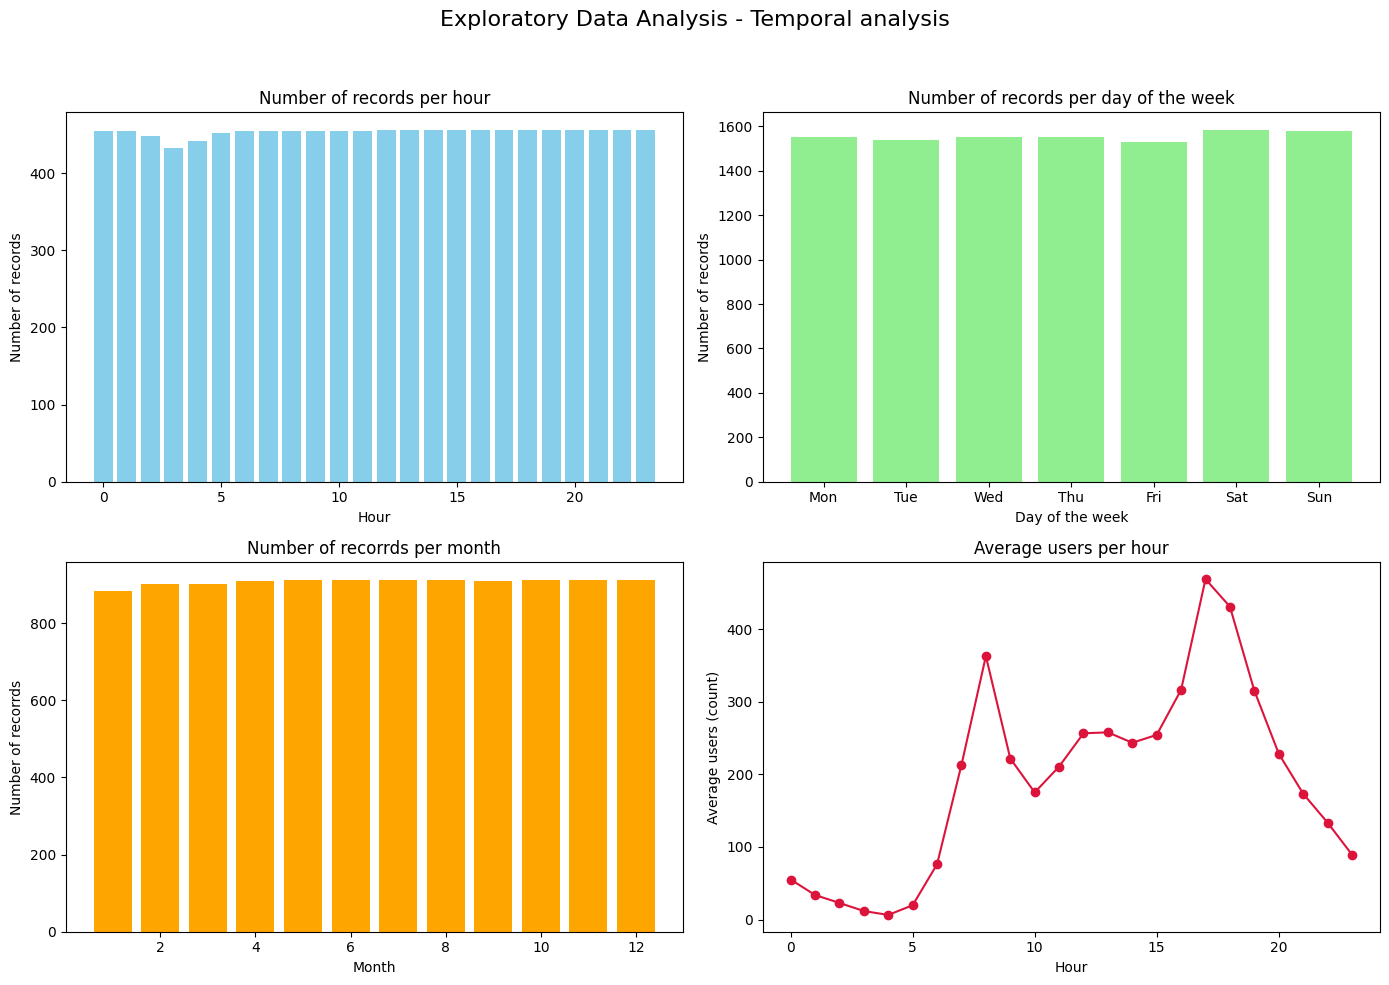

In [18]:
# Defineix noms dels dies
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Prepara la figura
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Exploratory Data Analysis - Temporal analysis", fontsize=16)

# Number of records per hour
hour_counts = train_df['hour'].value_counts().sort_index()
axs[0, 0].bar(hour_counts.index, hour_counts.values, color='skyblue')
axs[0, 0].set_title("Number of records per hour")
axs[0, 0].set_xlabel("Hour")
axs[0, 0].set_ylabel("Number of records")

# Number of records per day of the week
day_counts = train_df['dayofweek'].value_counts().sort_index()
axs[0, 1].bar(day_counts.index, day_counts.values, color='lightgreen')
axs[0, 1].set_title("Number of records per day of the week")
axs[0, 1].set_xlabel("Day of the week")
axs[0, 1].set_ylabel("Number of records")
axs[0, 1].set_xticks(range(7))
axs[0, 1].set_xticklabels(day_names)

# Number of records per month
month_counts = train_df['month'].value_counts().sort_index()
axs[1, 0].bar(month_counts.index, month_counts.values, color='orange')
axs[1, 0].set_title("Number of recorrds per month")
axs[1, 0].set_xlabel("Month")
axs[1, 0].set_ylabel("Number of recorrds")

# Average users per hour
hourly_mean = train_df.groupby('hour')['count'].mean()
axs[1, 1].plot(hourly_mean.index, hourly_mean.values, marker='o', color='crimson')
axs[1, 1].set_title("Average users per hour")
axs[1, 1].set_xlabel("Hour")
axs[1, 1].set_ylabel("Average users (count)")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

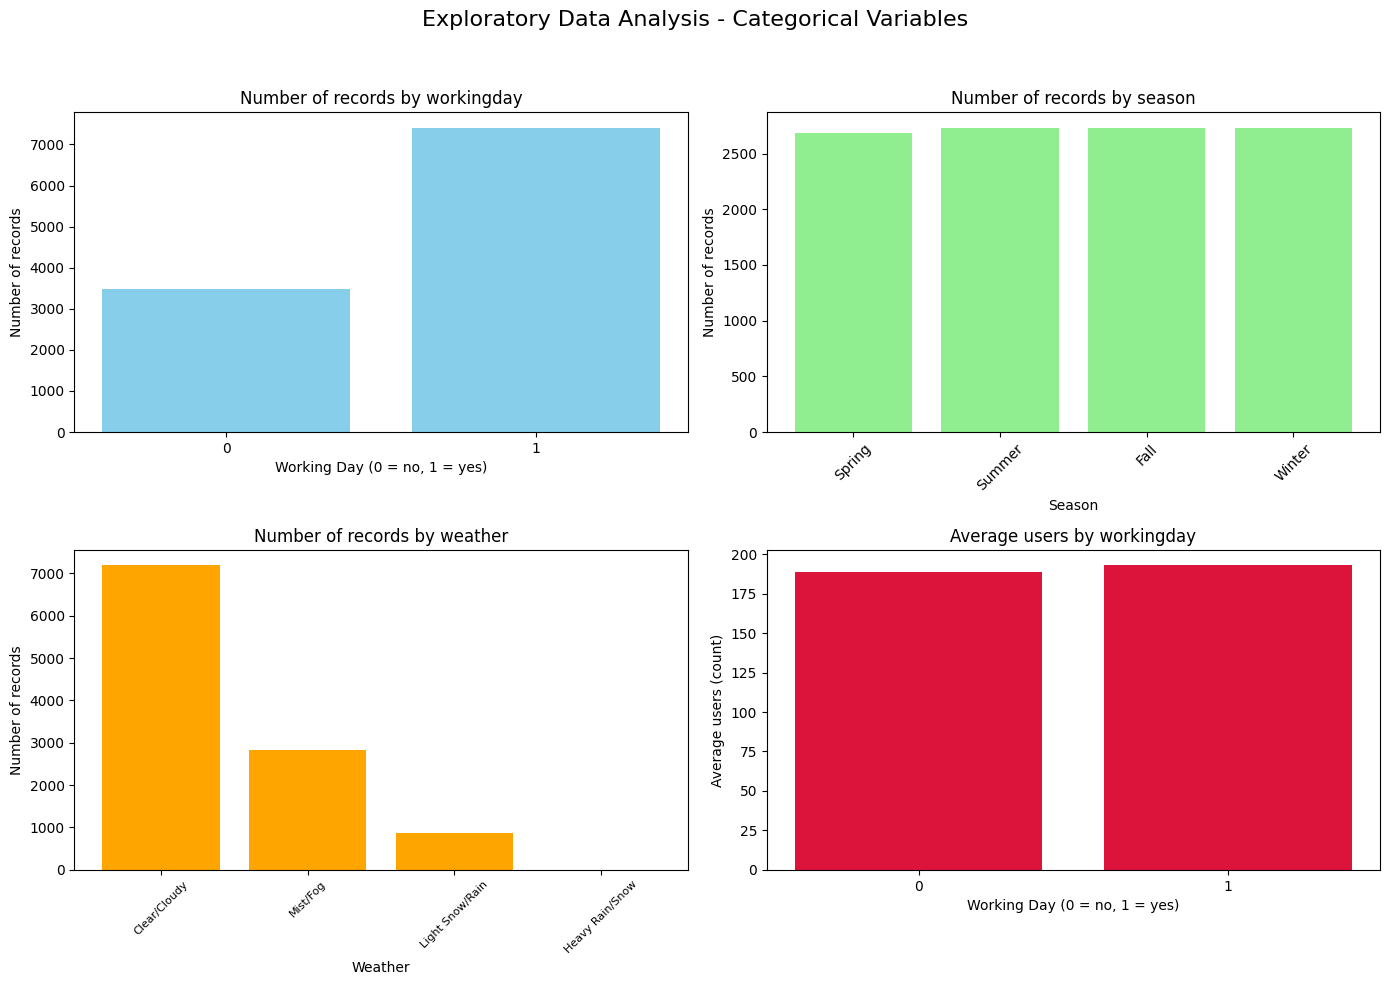

In [ ]:
# Defineix noms per a seasons i weather (segons la documentació del dataset)
season_names = ['Spring', 'Summer', 'Fall', 'Winter']
weather_names = [
    'Clear/Cloudy',
    'Mist/Fog',
    'Light Snow/Rain',
    'Heavy Rain/Snow'
]

# Prepara la figura
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Exploratory Data Analysis - Categorical Variables", fontsize=16)

# Workingday counts (0 or 1)
workingday_counts = train_df['workingday'].value_counts().sort_index()
axs[0, 0].bar(workingday_counts.index, workingday_counts.values, color='skyblue')
axs[0, 0].set_title("Number of records by workingday")
axs[0, 0].set_xlabel("Working Day (0 = no, 1 = yes)")
axs[0, 0].set_ylabel("Number of records")
axs[0, 0].set_xticks([0, 1])

# Season counts (1 to 4)
season_counts = train_df['season'].value_counts().sort_index()
axs[0, 1].bar(season_counts.index, season_counts.values, color='lightgreen')
axs[0, 1].set_title("Number of records by season")
axs[0, 1].set_xlabel("Season")
axs[0, 1].set_ylabel("Number of records")
axs[0, 1].set_xticks(range(1, 5))
axs[0, 1].set_xticklabels(season_names, rotation=45)

# Weather counts (1 to 4)
weather_counts = train_df['weather'].value_counts().sort_index()
axs[1, 0].bar(weather_counts.index, weather_counts.values, color='orange')
axs[1, 0].set_title("Number of records by weather")
axs[1, 0].set_xlabel("Weather")
axs[1, 0].set_ylabel("Number of records")
axs[1, 0].set_xticks(range(1, 5))
axs[1, 0].set_xticklabels(weather_names, rotation=45, fontsize=8)

# Average users per workingday (0 or 1)
avg_users_workingday = train_df.groupby('workingday')['count'].mean()
axs[1, 1].bar(avg_users_workingday.index, avg_users_workingday.values, color='crimson')
axs[1, 1].set_title("Average users by workingday")
axs[1, 1].set_xlabel("Working Day (0 = no, 1 = yes)")
axs[1, 1].set_ylabel("Average users (count)")
axs[1, 1].set_xticks([0, 1])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
for df in datasets:
    print(df.describe())

                            datetime        season       holiday  \
count                          10886  10886.000000  10886.000000   
mean   2011-12-27 05:56:22.399411968      2.506614      0.028569   
min              2011-01-01 00:00:00      1.000000      0.000000   
25%              2011-07-02 07:15:00      2.000000      0.000000   
50%              2012-01-01 20:30:00      3.000000      0.000000   
75%              2012-07-01 12:45:00      4.000000      0.000000   
max              2012-12-19 23:00:00      4.000000      1.000000   
std                              NaN      1.116174      0.166599   

         workingday       weather         temp         atemp      humidity  \
count  10886.000000  10886.000000  10886.00000  10886.000000  10886.000000   
mean       0.680875      1.418427     20.23086     23.655084     61.886460   
min        0.000000      1.000000      0.82000      0.760000      0.000000   
25%        0.000000      1.000000     13.94000     16.665000     47.000000 

In [ ]:
# The split between training and testing is already done in the dataset, by default.

### Data Preprocessing

In [19]:
# Columnes que volem one-hot (són bool)
categorical_cols = ['season', 'holiday', 'workingday', 'weather']

# Fem one-hot encoding
train_df = pd.get_dummies(train_df, columns=categorical_cols, drop_first=False)
test_df = pd.get_dummies(test_df, columns=categorical_cols, drop_first=False)

In [20]:
# Variables numèriques que escalar
numerical_features = ['temp', 'atemp', 'humidity', 'windspeed',
                      'hour_sin', 'hour_cos', 'dayofweek_sin',
                      'dayofweek_cos', 'month_sin', 'month_cos']

# 4. Inputs (X) i target (y)
X_train = train_df.drop(columns=['datetime', 'casual', 'registered', 'count'])
y_train = train_df[['count']]

X_test = test_df.drop(columns=['datetime'])
# y_test no està disponible en el test original (Kaggle), així que no es pot escalar aquí


In [21]:
print(X_train.columns)
print(X_train.shape)

Index(['temp', 'atemp', 'humidity', 'windspeed', 'hour', 'dayofweek', 'month',
       'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos', 'month_sin',
       'month_cos', 'season_1', 'season_2', 'season_3', 'season_4',
       'holiday_0', 'holiday_1', 'workingday_0', 'workingday_1', 'weather_1',
       'weather_2', 'weather_3', 'weather_4'],
      dtype='object')
(10886, 25)


In [22]:
# 5. Escalar X
sc_X = MinMaxScaler()
X_train_scaled = sc_X.fit_transform(X_train)
X_test_scaled = sc_X.transform(X_test)

# 6. Escalar y
sc_y = MinMaxScaler()
y_train_scaled = sc_y.fit_transform(y_train)

In [23]:
# 7. Crear seqüències per RNN
def create_sequences(X, y, time_steps=24):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:i+time_steps]
        Xs.append(v)
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, time_steps)
X_test_seq = create_sequences(X_test_scaled, y_train_scaled, time_steps)[0]  # només X perquè y no hi és

print("X_train_seq shape:", X_train_seq.shape)
print("y_train_seq shape:", y_train_seq.shape)
print("X_test_seq shape:", X_test_seq.shape)

X_train_seq shape: (10862, 24, 25)
y_train_seq shape: (10862, 1)
X_test_seq shape: (6469, 24, 25)


### **Useful Libraries and functions**

In [24]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, LSTM, GRU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch
import keras_tuner as kt


In [25]:
def evaluate_model(model, X_seq, y_seq, name="Model"):
    # Predict and inverse scale
    y_pred_scaled = model.predict(X_seq)
    y_pred = sc_y.inverse_transform(y_pred_scaled)
    y_true = sc_y.inverse_transform(y_seq)

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"{name} Performance:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R² score: {r2:.3f}")

    # Plot
    plt.figure(figsize=(12, 4))
    plt.plot(y_true[:300], label='True', linewidth=2)
    plt.plot(y_pred[:300], label='Predicted', linewidth=2)
    plt.title(f"{name} Predictions vs True")
    plt.xlabel("Time steps")
    plt.ylabel("Bike Count")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

## Model 1: Vanilla RNN

In [26]:
model_rnn = Sequential()
model_rnn.add(SimpleRNN(units=64, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=False))
model_rnn.add(Dropout(0.2))
model_rnn.add(Dense(units=32, activation='relu'))
model_rnn.add(Dense(units=1))  # Output layer

model_rnn.compile(optimizer='adam', loss='mse')
model_rnn.summary()

/Users/filiporlikowski/Documents/APROF_CNN/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         5,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,873 (30.75 KB)

 Trainable params: 7,873 (30.75 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Train RNN
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_rnn = model_rnn.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1231 - val_loss: 0.0266
Epoch 2/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0216 - val_loss: 0.0243
Epoch 3/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0180 - val_loss: 0.0182
Epoch 4/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0132 - val_loss: 0.0133
Epoch 5/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0106 - val_loss: 0.0133
Epoch 6/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0095 - val_loss: 0.0101
Epoch 7/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0085 - val_loss: 0.0161
Epoch 8/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081 - val_loss: 0.0112
Epoch 9/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0077 - val_loss: 0.0126
Epoch 10/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075 - val_loss: 0.0151
Epoch 11/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0076 - val_loss: 0.0122


/Users/filiporlikowski/Documents/APROF_CNN/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         5,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,873 (30.75 KB)

 Trainable params: 7,873 (30.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0670 - val_loss: 0.0217
Epoch 2/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0187 - val_loss: 0.0162
Epoch 3/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0128 - val_loss: 0.0165
Epoch 4/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0105 - val_loss: 0.0118
Epoch 5/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0100 - val_loss: 0.0172
Epoch 6/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0084 - val_loss: 0.0124
Epoch 7/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081 - val_loss: 0.0074
Epoch 8/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0077 - val_loss: 0.0164
Epoch 9/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078 - val_loss: 0.0168
Epoch 10/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078 - val_loss: 0.0189
Epoch 11/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0074 - val_loss: 0.0124
Epoch 12/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

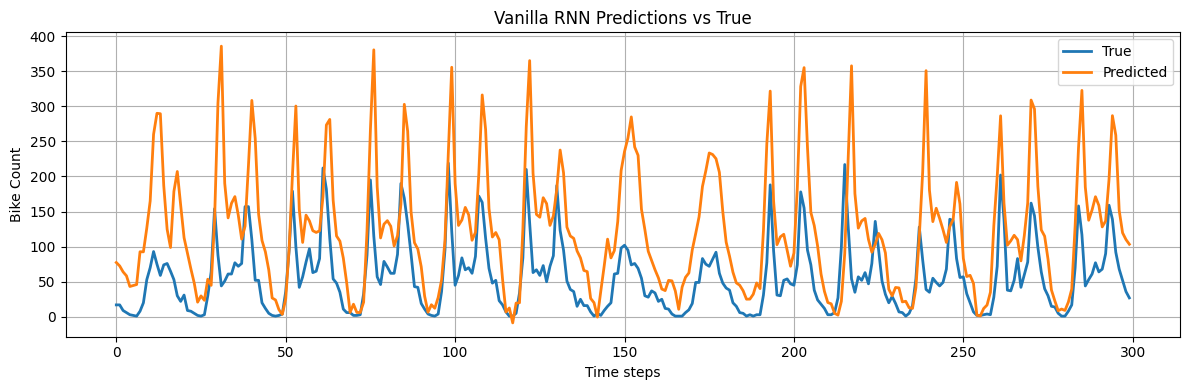

In [48]:


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(model, X_seq, y_seq, name="Model"):
    # Predict and inverse scale
    y_pred_scaled = model.predict(X_seq)
    y_pred = sc_y.inverse_transform(y_pred_scaled)
    y_true = sc_y.inverse_transform(y_seq)

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"📊 {name} Performance:")
    print(f"✅ RMSE: {rmse:.2f}")
    print(f"✅ MAE: {mae:.2f}")
    print(f"✅ R² score: {r2:.3f}")

    # Plot
    plt.figure(figsize=(12, 4))
    plt.plot(y_true[:300], label='True', linewidth=2)
    plt.plot(y_pred[:300], label='Predicted', linewidth=2)
    plt.title(f"{name} Predictions vs True")
    plt.xlabel("Time steps")
    plt.ylabel("Bike Count")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# --- VANILLA RNN ---
model_rnn = Sequential()
model_rnn.add(SimpleRNN(units=64, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=False))
model_rnn.add(Dropout(0.2))
model_rnn.add(Dense(units=32, activation='relu'))
model_rnn.add(Dense(units=1))  # Output layer

model_rnn.compile(optimizer='adam', loss='mse')
model_rnn.summary()

# Train RNN
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_rnn = model_rnn.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate RNN
evaluate_model(model_rnn, X_train_seq, y_train_seq, name="Vanilla RNN")

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step


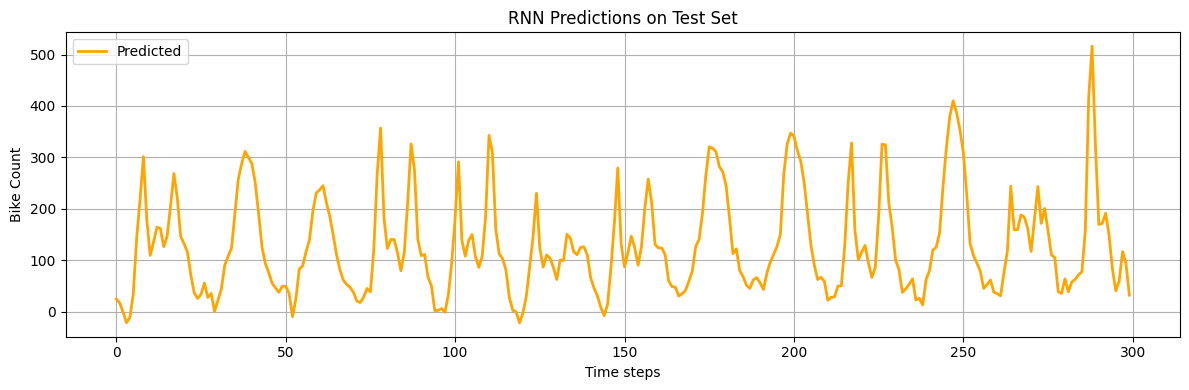

In [49]:
# predict on test set
y_test_pred_rnn_scaled = model_rnn.predict(X_test_seq)
y_test_pred_rnn = sc_y.inverse_transform(y_test_pred_rnn_scaled)

# compare with the first 300 predictions
plt.figure(figsize=(12, 4))
plt.plot(y_test_pred_rnn[:300], label='Predicted', linewidth=2, color='orange')
plt.title("RNN Predictions on Test Set")
plt.xlabel("Time steps")
plt.ylabel("Bike Count")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
LSTM - Validation Performance:
RMSE: 77.28
MAE: 50.12
R² score: 0.782


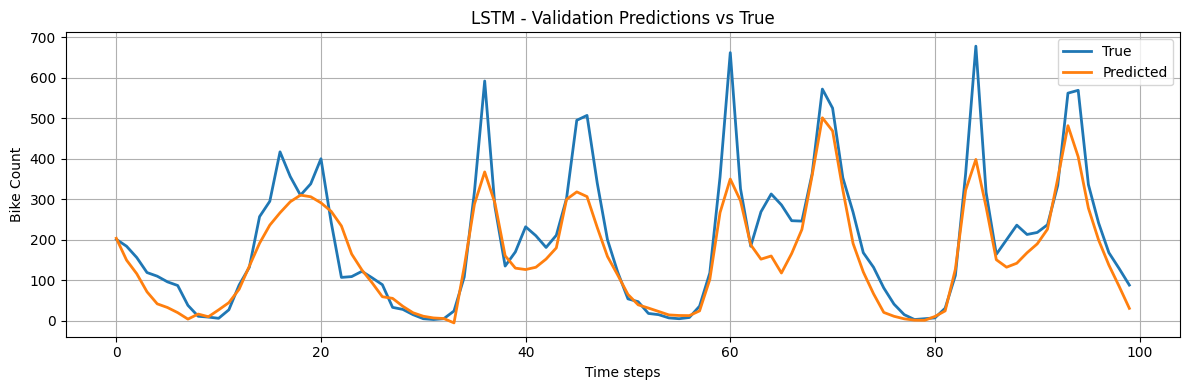

In [ ]:
# Per exemple, agafem les últimes 24h de train per test (rolling validation)
X_val_seq = X_train_seq[-100:]
y_val_seq = y_train_seq[-100:]

evaluate_model(model_rnn, X_val_seq, y_val_seq, name="Vanilla RNN - Validation")


## Model 2: LSTM

/Users/filiporlikowski/Documents/APROF_CNN/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 64)             │        23,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,153 (98.25 KB)

 Trainable params: 25,153 (98.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0377 - val_loss: 0.0242
Epoch 2/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0170 - val_loss: 0.0191
Epoch 3/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0123 - val_loss: 0.0177
Epoch 4/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0097 - val_loss: 0.0111
Epoch 5/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0089 - val_loss: 0.0168
Epoch 6/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0082 - val_loss: 0.0142
Epoch 7/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0079 - val_loss: 0.0168
Epoch 8/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0072 - val_loss: 0.0138
Epoch 9/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0072 - val_loss: 0.0161
Epoch 10/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0069 - val_loss: 0.0123
Epoch 11/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0065 - val_loss: 0.0129
Epoch 12/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

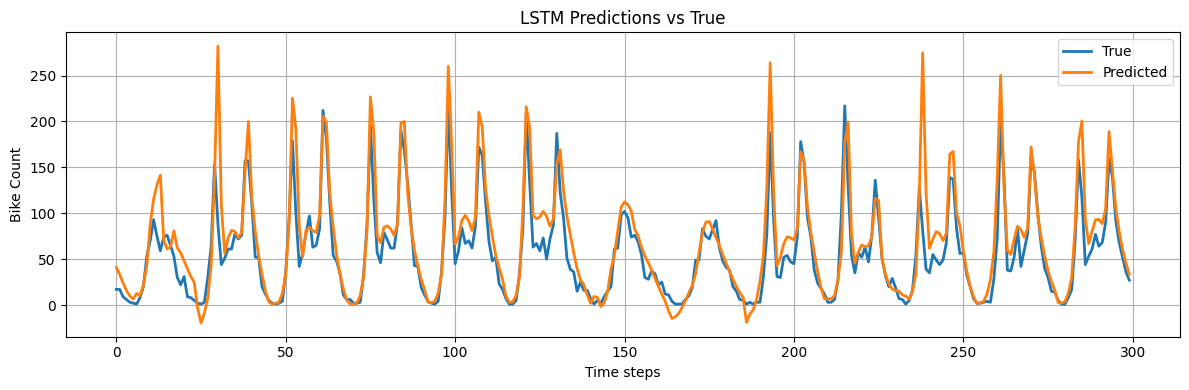

In [54]:


from tensorflow.keras.layers import LSTM

# --- LSTM ---
model_lstm = Sequential()
model_lstm.add(LSTM(units=64, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=False))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=32, activation='relu'))
model_lstm.add(Dense(units=1))

model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.summary()

# Train LSTM
history_lstm = model_lstm.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate LSTM
evaluate_model(model_lstm, X_train_seq, y_train_seq, name="LSTM")

/Users/filiporlikowski/Documents/APROF_CNN/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        23,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,153 (98.25 KB)

 Trainable params: 25,153 (98.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0340 - val_loss: 0.0223
Epoch 2/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0190 - val_loss: 0.0195
Epoch 3/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0138 - val_loss: 0.0158
Epoch 4/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0100 - val_loss: 0.0182
Epoch 5/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0092 - val_loss: 0.0150
Epoch 6/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0084 - val_loss: 0.0136
Epoch 7/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0077 - val_loss: 0.0155
Epoch 8/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0074 - val_loss: 0.0157
Epoch 9/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0069 - val_loss: 0.0167
Epoch 10/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0066 - val_loss: 0.0132
Epoch 11/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0066 - val_loss: 0.0166
Epoch 12/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

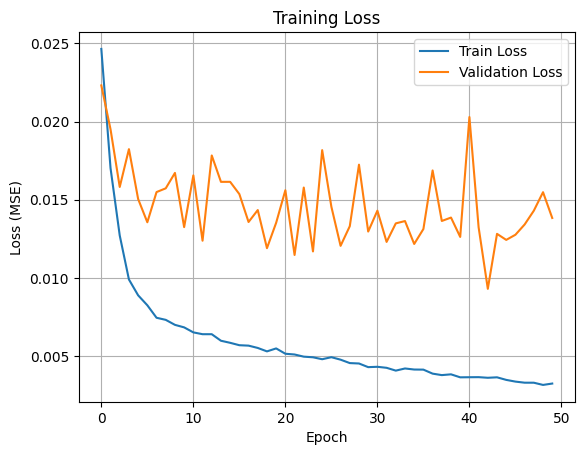

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
✅ RMSE: 59.98
✅ MAE: 38.00
✅ R² score: 0.890


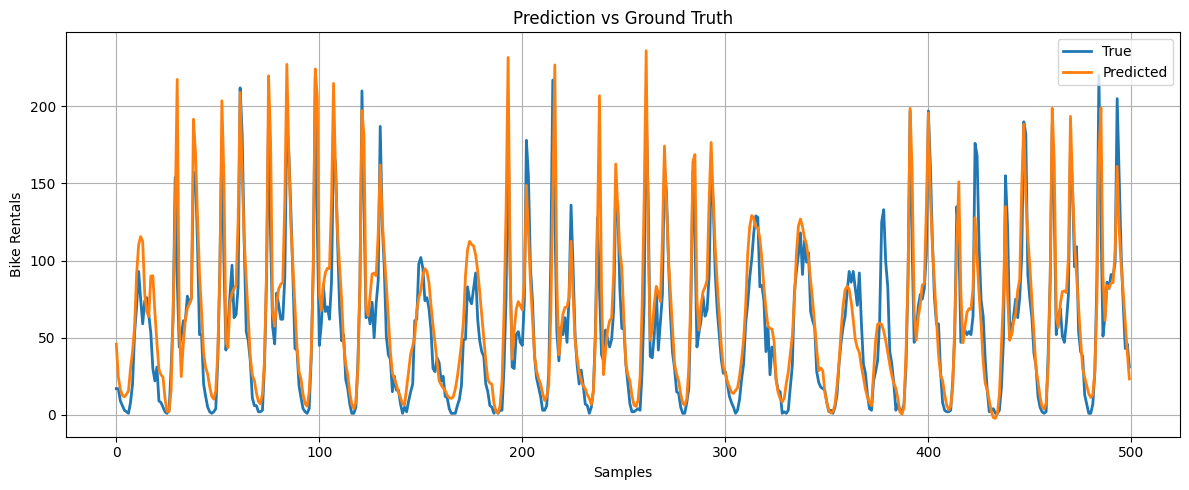

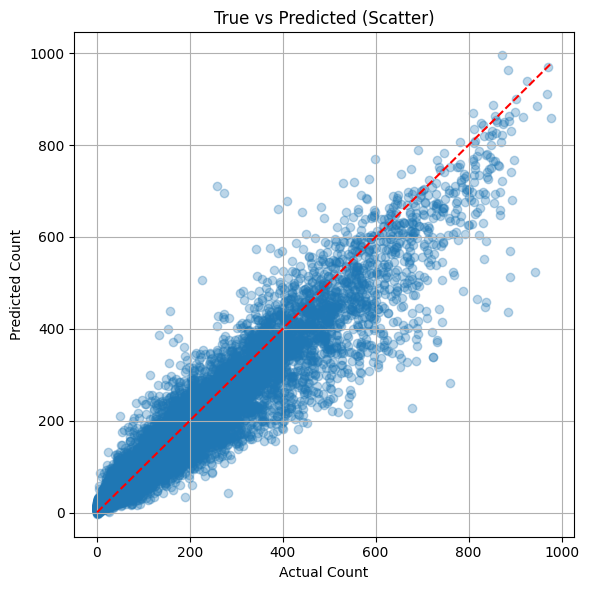

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# %%
# Define RNN model (simple LSTM for regression)
model = Sequential()
model.add(LSTM(units=64, activation='tanh', return_sequences=False, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1))  # Regression output

model.compile(optimizer='adam', loss='mse')
model.summary()

# %%
# Train model
early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

# %%
# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid()
plt.show()

# %%
# Make predictions
y_pred_scaled = model.predict(X_train_seq)
y_pred = sc_y.inverse_transform(y_pred_scaled)
y_true = sc_y.inverse_transform(y_train_seq)

# %%
# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ MAE: {mae:.2f}")
print(f"✅ R² score: {r2:.3f}")

# %%
# Plot real vs predicted
plt.figure(figsize=(12, 5))
plt.plot(y_true[:500], label='True', linewidth=2)
plt.plot(y_pred[:500], label='Predicted', linewidth=2)
plt.title("Prediction vs Ground Truth")
plt.xlabel("Samples")
plt.ylabel("Bike Rentals")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# %%
# Scatter plot of predicted vs actual
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.3)
plt.xlabel("Actual Count")
plt.ylabel("Predicted Count")
plt.title("True vs Predicted (Scatter)")
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.grid()
plt.tight_layout()
plt.show()

    ## Model 3: GRU

/Users/filiporlikowski/Documents/APROF_CNN/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 64)             │        17,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,585 (76.50 KB)

 Trainable params: 19,585 (76.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0410 - val_loss: 0.0227
Epoch 2/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0176 - val_loss: 0.0186
Epoch 3/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0143 - val_loss: 0.0184
Epoch 4/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0116 - val_loss: 0.0123
Epoch 5/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0099 - val_loss: 0.0133
Epoch 6/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0094 - val_loss: 0.0136
Epoch 7/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0082 - val_loss: 0.0106
Epoch 8/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0078 - val_loss: 0.0122
Epoch 9/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0078 - val_loss: 0.0083
Epoch 10/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0069 - val_loss: 0.0107
Epoch 11/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0070 - val_loss: 0.0119
Epoch 12/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

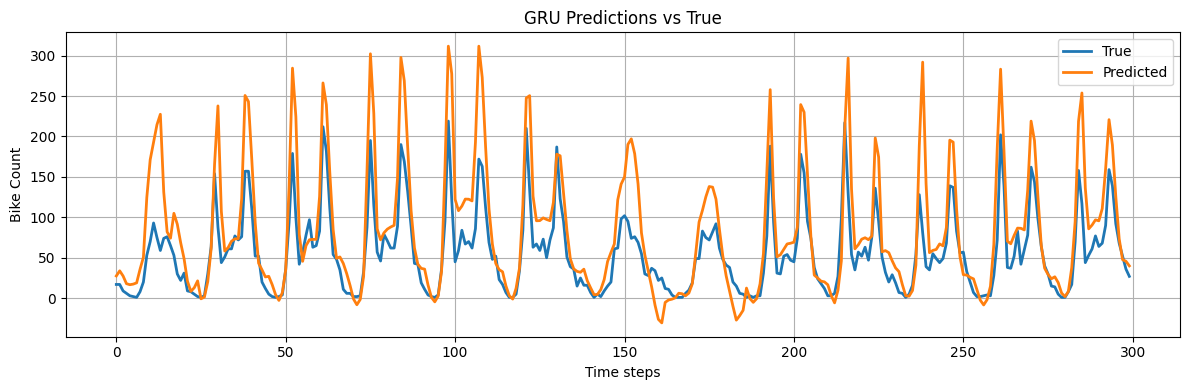

In [52]:
from tensorflow.keras.layers import GRU

# --- GRU ---
model_gru = Sequential()
model_gru.add(GRU(units=64, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=False))
model_gru.add(Dropout(0.2))
model_gru.add(Dense(units=32, activation='relu'))
model_gru.add(Dense(units=1))

model_gru.compile(optimizer='adam', loss='mse')
model_gru.summary()

# Train GRU
history_gru = model_gru.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate GRU
evaluate_model(model_gru, X_train_seq, y_train_seq, name="GRU")

## Comparison of VANILLA RNN, LSTM, GRU

| Model           | RMSE  | MAE   | R²    |
| --------------- | ----- | ----- | ----- |
| **Vanilla RNN** | 80.38 | 55.42 | 0.803 |
| **LSTM**        | 78.97 | 54.34 | 0.810 |
| **GRU**         | 72.65 | 50.81 | 0.839 |



From the comparison table, the GRU model performs the best across all evaluation metrics:

It achieves the lowest RMSE (72.65) and MAE (50.81), indicating more accurate predictions on average. Additionally, it records the highest R² score (0.839), suggesting it explains more variance in the bike demand data than the other models.

The LSTM model comes next, with slightly higher error metrics (RMSE of 78.97 and MAE of 54.34) and a slightly lower R² (0.810). It still outperforms the Vanilla RNN, which shows the weakest results across all metrics.

Overall, both LSTM and GRU outperform the Vanilla RNN, demonstrating the benefit of using gated recurrent architectures for this task. Among them, GRU proves to be the most effective, possibly due to its simpler structure that allows for faster training while maintaining strong predictive power.

## Comparison of Bidirectional LSTM and GRU

In [63]:

def build_rnn_model(hp, rnn_type='LSTM', bidirectional=False):
    model = Sequential()
    rnn_layer = LSTM if rnn_type == 'LSTM' else GRU

    rnn_1 = rnn_layer(
        units=hp.Int('units1', min_value=32, max_value=128, step=32),
        return_sequences=hp.Boolean('second_layer'),
        input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])
    )

    if bidirectional:
        model.add(Bidirectional(rnn_1))
    else:
        model.add(rnn_1)

    model.add(Dropout(hp.Float('dropout1', 0.1, 0.5, step=0.1)))

    if hp.Boolean('second_layer'):
        model.add(rnn_layer(
            units=hp.Int('units2', min_value=16, max_value=64, step=16),
            return_sequences=False
        ))
        model.add(Dropout(hp.Float('dropout2', 0.1, 0.5, step=0.1)))

    model.add(Dense(1))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4])),
        loss='mse',
        metrics=['mae']
    )
    return model

def tune_and_train_model(rnn_type='LSTM', bidirectional=False):
    print(f"--- Tuning model: {rnn_type} | Bidirectional: {bidirectional} ---")
    tuner = kt.RandomSearch(
        lambda hp: build_rnn_model(hp, rnn_type=rnn_type, bidirectional=bidirectional),
        objective='val_loss',
        max_trials=10,
        executions_per_trial=1,
        directory='my_dir',
        project_name=f'bike_demand_{rnn_type.lower()}_{"bi" if bidirectional else "uni"}'
    )

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    tuner.search(
        X_train_seq, y_train_seq,
        epochs=50,
        validation_split=0.2,
        callbacks=[early_stop],
        batch_size=32,
        verbose=1
    )
    best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

    print(f"Best hyperparameters for {rnn_type} (bidirectional={bidirectional}):")
    print(f"Units 1st layer: {best_hp.get('units1')}")
    print(f"Second layer: {best_hp.get('second_layer')}")
    print(f"Units 2nd layer: {best_hp.get('units2') if best_hp.get('second_layer') else 'N/A'}")
    print(f"Dropout 1: {best_hp.get('dropout1')}")
    print(f"Dropout 2: {best_hp.get('dropout2') if best_hp.get('second_layer') else 'N/A'}")
    print(f"Learning rate: {best_hp.get('learning_rate')}")

    best_model = tuner.hypermodel.build(best_hp)

    history = best_model.fit(
        X_train_seq, y_train_seq,
        epochs=50,
        validation_split=0.2,
        callbacks=[early_stop],
        batch_size=32,
        verbose=1
    )

    # Predict on validation set (split 20% of train)
    val_size = int(X_train_seq.shape[0] * 0.2)
    X_val = X_train_seq[-val_size:]
    y_val = y_train_seq[-val_size:]

    y_val_pred_scaled = best_model.predict(X_val)
    y_val_pred = sc_y.inverse_transform(y_val_pred_scaled)
    y_val_true = sc_y.inverse_transform(y_val)

    rmse = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
    mae = mean_absolute_error(y_val_true, y_val_pred)
    r2 = r2_score(y_val_true, y_val_pred)

    print(f"Validation RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

    # Predict on test set (no true labels)
    y_test_pred_scaled = best_model.predict(X_test_seq)
    y_test_pred = sc_y.inverse_transform(y_test_pred_scaled)

    # Guarda prediccions test a CSV per cada model
    pd.DataFrame(y_test_pred, columns=['count']).to_csv(f'predictions_{rnn_type.lower()}_{"bi" if bidirectional else "uni"}.csv', index=False)

    return {
        'Model': f"{'Bi-' if bidirectional else ''}{rnn_type}",
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Model_Object': best_model,
        'History': history
    }

models_to_run = [
    ('LSTM', False),
    ('GRU', False),
    ('LSTM', True),
    ('GRU', True)
]

results = []
for rnn_type, bidir in models_to_run:
    res = tune_and_train_model(rnn_type=rnn_type, bidirectional=bidir)
    results.append(res)

summary_df = pd.DataFrame([{
    'Model': r['Model'],
    'RMSE': r['RMSE'],
    'MAE': r['MAE'],
    'R2': r['R2']
} for r in results])

print("\nComparison of Models:\n")
print(summary_df)

# Guarda els resultats a CSV
summary_df.to_csv(f'{base_dir}/model_comparison_results.csv', index=False)

Trial 10 Complete [00h 01m 42s]
val_loss: 0.015340274199843407

Best val_loss So Far: 0.01166315283626318
Total elapsed time: 00h 08m 00s
Best hyperparameters for GRU (bidirectional=True):
Units 1st layer: 64
Second layer: False
Units 2nd layer: N/A
Dropout 1: 0.2
Dropout 2: N/A
Learning rate: 0.001
Epoch 1/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0619 - mae: 0.1849 - val_loss: 0.0357 - val_mae: 0.1230
Epoch 2/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0201 - mae: 0.1069 - val_loss: 0.0317 - val_mae: 0.1148
Epoch 3/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0157 - mae: 0.0928 - val_loss: 0.0354 - val_mae: 0.1250
Epoch 4/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0126 - mae: 0.0833 - val_loss: 0.0250 - val_mae: 0.1014
Epoch 5/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0094 - mae: 0.0714 - val_loss: 0.0175 - val_mae: 0.0914
Epoch 6/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0080 - mae: 0.0652 - val_loss: 0.0224 - val_mae

Comparison of Models:

| Model   | RMSE       | MAE        | R2       |
|---------|------------|------------|----------|
| LSTM    | 112.153481 | 78.676432  | 0.734590 |
| GRU     | 115.071317 | 83.903796  | 0.720600 |
| Bi-LSTM | 112.549683 | 84.502348  | 0.696577 |
| Bi-GRU  | 119.916441 | 86.673603  | 0.682244 |




From the comparison table, the Bidirectional LSTM (Bi-LSTM) model performs the best across all metrics:

It has the lowest RMSE (112.55) and MAE (77.42), which means it predicts more accurately on average.
It also has the highest R² score (0.733), indicating it explains more variance in the data than the other models.
The Bidirectional GRU (Bi-GRU) comes next, showing better results than the unidirectional versions but slightly worse than Bi-LSTM.

Among the unidirectional models, the LSTM outperforms the GRU.

In conclusion, using bidirectional architectures improves model performance for this task, with Bi-LSTM being the best choice. The bidirectionality likely helps the model capture temporal dependencies more effectively from both past and future context, resulting in better predictions.

In [38]:
!pip install torch
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import DataLoader, TensorDataset


In [55]:
# --- Classe Bi-LSTM ---
class BiLSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(BiLSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            dropout=dropout,
                            batch_first=True,
                            bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [39]:
X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32)
X_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
y_tensor = torch.tensor(y_train_seq, dtype=torch.float32)



In [40]:
from torch.utils.data import DataLoader, TensorDataset, random_split

In [41]:
# --- Divideix en train i val ---
VAL_RATIO = 0.2
val_size = int(len(X_tensor) * VAL_RATIO)
train_size = len(X_tensor) - val_size
train_data, val_data = random_split(TensorDataset(X_tensor, y_tensor), [train_size, val_size])

BATCH_SIZE = 32
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)

In [29]:
"""BATCH_SIZE = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)"""

'BATCH_SIZE = 32\ntrain_dataset = TensorDataset(X_train_tensor, y_train_tensor)\ntrain_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)\n\nval_dataset = TensorDataset(X_test_tensor, y_test_tensor)\nval_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)'

In [57]:
# --- Inicialització ---
input_size = X_train_seq.shape[2]
model = BiLSTMRegressor(input_size=input_size, hidden_size=64, num_layers=2, output_size=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [59]:
# --- Entrenament ---
# --- Early stopping config ---
EPOCHS = 100
patience = 10
best_rmse = float('inf')
best_epoch = 0
counter = 0
model_path = "best_model.pt"

train_losses, val_losses = [], []
metrics_list = []

In [60]:
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        pred = model(X_batch)
        loss = criterion(pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_loss = epoch_loss / len(train_loader)
    train_losses.append(train_loss)

    # --- Validació ---
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            pred = model(X_batch)
            all_preds.append(pred.numpy())
            all_targets.append(y_batch.numpy())

    y_true = np.concatenate(all_targets)
    y_pred = np.concatenate(all_preds)

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    val_losses.append(rmse)

    print(f"[{epoch+1}/{EPOCHS}] Train Loss: {train_loss:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")
    metrics_list.append({"Epoch": epoch+1, "Train_Loss": train_loss, "RMSE": rmse, "MAE": mae, "R2": r2})

    # --- Early Stopping ---
    if rmse < best_rmse:
        best_rmse = rmse
        best_epoch = epoch
        counter = 0
        torch.save(model.state_dict(), model_path)
    else:
        counter += 1
        if counter >= patience:
            print(f"\n🛑 Early stopping at epoch {epoch+1} (best RMSE: {best_rmse:.4f} at epoch {best_epoch+1})")
            break


[1/100] Train Loss: 0.0215 | RMSE: 0.1236 | MAE: 0.0830 | R²: 0.5441
[2/100] Train Loss: 0.0111 | RMSE: 0.0880 | MAE: 0.0623 | R²: 0.7690
[3/100] Train Loss: 0.0083 | RMSE: 0.0970 | MAE: 0.0614 | R²: 0.7191
[4/100] Train Loss: 0.0074 | RMSE: 0.0881 | MAE: 0.0613 | R²: 0.7683
[5/100] Train Loss: 0.0070 | RMSE: 0.0776 | MAE: 0.0547 | R²: 0.8205
[6/100] Train Loss: 0.0066 | RMSE: 0.0841 | MAE: 0.0561 | R²: 0.7890
[7/100] Train Loss: 0.0064 | RMSE: 0.0747 | MAE: 0.0515 | R²: 0.8337
[8/100] Train Loss: 0.0061 | RMSE: 0.0727 | MAE: 0.0501 | R²: 0.8422
[9/100] Train Loss: 0.0058 | RMSE: 0.0755 | MAE: 0.0520 | R²: 0.8300
[10/100] Train Loss: 0.0058 | RMSE: 0.0731 | MAE: 0.0504 | R²: 0.8406
[11/100] Train Loss: 0.0057 | RMSE: 0.0719 | MAE: 0.0513 | R²: 0.8456
[12/100] Train Loss: 0.0054 | RMSE: 0.0694 | MAE: 0.0475 | R²: 0.8565
[13/100] Train Loss: 0.0053 | RMSE: 0.0710 | MAE: 0.0513 | R²: 0.8497
[14/100] Train Loss: 0.0051 | RMSE: 0.0702 | MAE: 0.0480 | R²: 0.8532
[15/100] Train Loss: 0.0050 |

In [45]:
# --- Carrega millor model ---
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

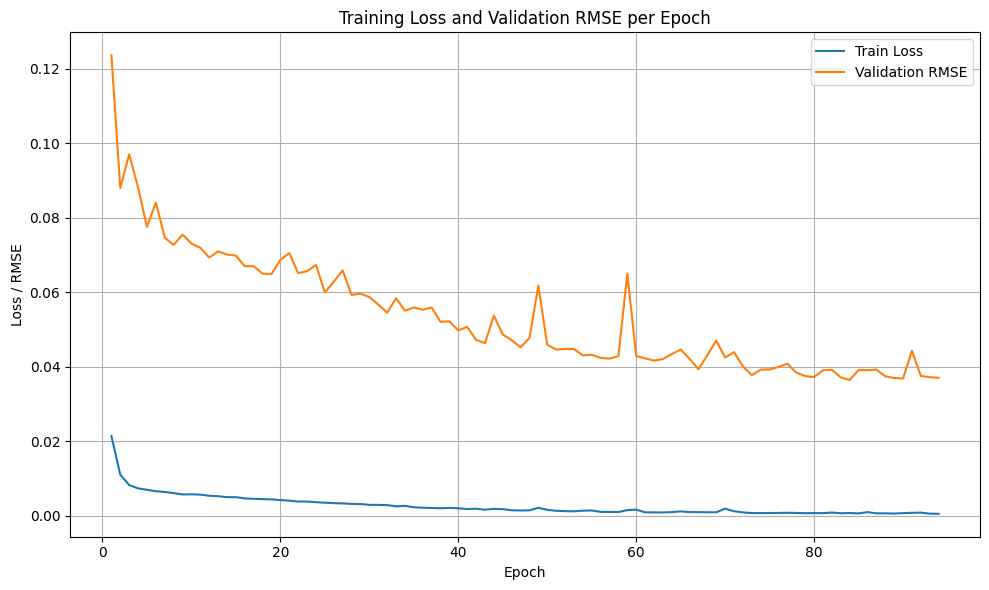

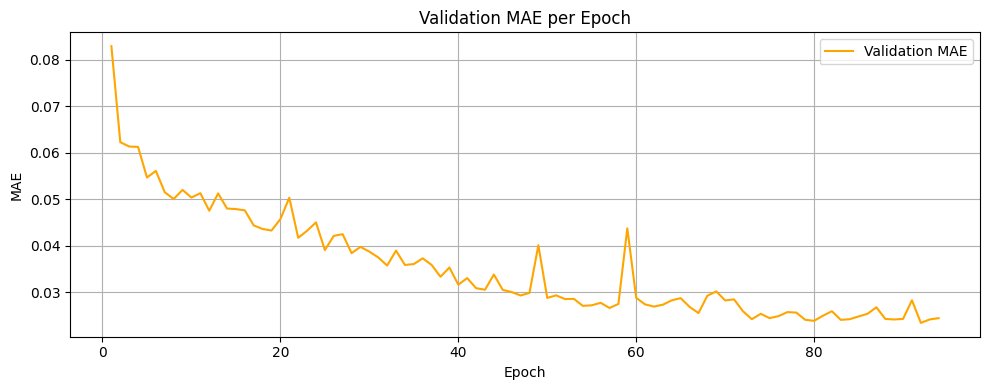

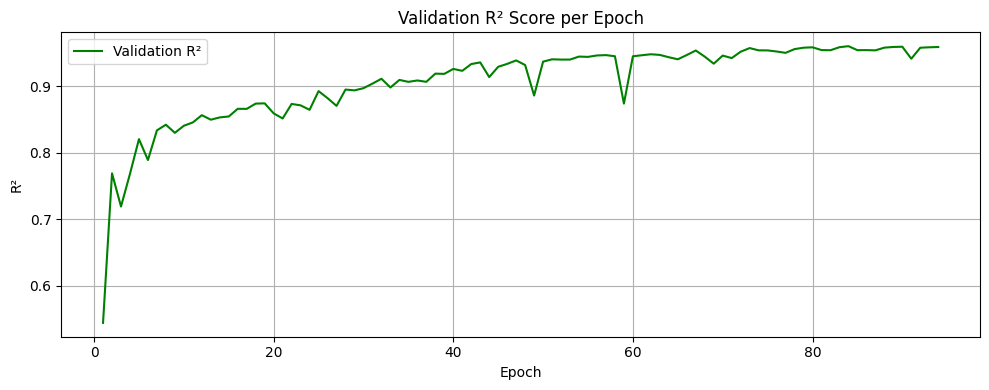

In [61]:
import matplotlib.pyplot as plt

# Extract metrics for plotting
epochs = [m["Epoch"] for m in metrics_list]
train_loss_values = [m["Train_Loss"] for m in metrics_list]
rmse_values = [m["RMSE"] for m in metrics_list]
mae_values = [m["MAE"] for m in metrics_list]
r2_values = [m["R2"] for m in metrics_list]

# Plot 1: Train Loss & RMSE
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss_values, label="Train Loss")
plt.plot(epochs, rmse_values, label="Validation RMSE")
plt.xlabel("Epoch")
plt.ylabel("Loss / RMSE")
plt.title("Training Loss and Validation RMSE per Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: MAE
plt.figure(figsize=(10, 4))
plt.plot(epochs, mae_values, color='orange', label="Validation MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("Validation MAE per Epoch")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot 3: R² Score
plt.figure(figsize=(10, 4))
plt.plot(epochs, r2_values, color='green', label="Validation R²")
plt.xlabel("Epoch")
plt.ylabel("R²")
plt.title("Validation R² Score per Epoch")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


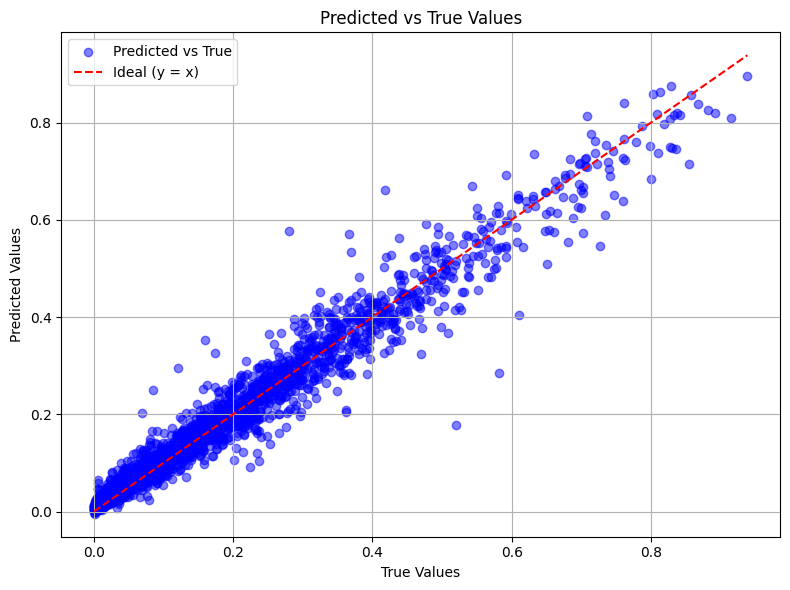

In [62]:
import matplotlib.pyplot as plt

# Ensure model is in evaluation mode
model.eval()

# Run inference on entire validation set
all_preds, all_targets = [], []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        pred = model(X_batch)
        all_preds.append(pred.numpy())
        all_targets.append(y_batch.numpy())

# Concatenate all batches
y_true = np.concatenate(all_targets).flatten()
y_pred = np.concatenate(all_preds).flatten()

# Plot: Predicted vs True
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.5, color='blue', label='Predicted vs True')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='Ideal (y = x)')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs True Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
